<a href="https://colab.research.google.com/github/gihuni99/Pytorch_Study/blob/main/Ch6_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch6.1 Image Classification을 위한 Neural Network

## 6.1.1 LeNet-5

Convolutional Neural Network 구조를 최초로 개발한 구조.

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/a790e7ad-2e02-4488-9e47-05dc289ea854)

C1: 5x5 Filter로 Convolution연산을 진행하여, 28x28 feature map 6개를 생성한다.

S2: Pooling layer로 Down sampling을 하여 feature map의 크기를 14x14로 줄인다.

C3: 5x5 Convolution 연산을 통해 10x10 feature map 16개를 생성한다.

S4: Down sampling을 통해 5x5 feature map으로 줄인다.

C5: 5x5 convolution연산을 통해 1x1 feature map 120개를 생성한다.

F6: Fully-connected layer를 통해 Classification이 가능하도록 한다.

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/a77f4c53-d1c0-48f1-9d0e-1e93fcdbe558)

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/b13a82d5-ee35-4337-bf6b-b16a0db3d75c)

이제 실습을 진행해보자.

### 'tqdm' 라이브러리 설치(progress를 bar형태로 보여준다)

In [1]:
pip install --user tqdm

### 필요한 라이브러리를 호출해준다.

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms#이미지 변환(전처리) 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim#경사 하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os#파일 경로에 대한 함수들을 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm#진행 상황을 가시적으로 표현해 주는데, 특히 모델의 학습 경과를 확인하고 싶을 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Preprocessing 코드 선언

In [4]:
class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform={
            'train':transforms.Compose([ #torchvision에서 transforms를 묶어주는 역할
                transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                #torchvision은 이미지를 읽을 때, 파이썬 라이브러리 PIL을 사용한다.
                #PIL은 이미지를 [0 255]의 pixel값을 갖는 (H W C) data로 불러온다.
                #효율적인 연산을 위해 torch.FloatTensor로 바꾸어야하는데,
                #[0.0 1.0]의 pixel을 갖는 (C H W) data로 변환하는 역할을 'ToTensor()'가 한다.
                transforms.ToTensor(),
                #pre-trained 모델들은 대부분 ImageNet으로 훈련되어 있다.
                #따라서 ImageNet데이터의 각 channel별 mean과 std값에 따라 normalization을 해주어야 한다.
                #mean: (0.485,0.456,0.406), std: (0.229,0.224,0.225)
                transforms.Normalize(mean,std)
                # +)참고 OpenCV를 사용하여 이미지를 불러오면 RGB가 아닌 BGR순서
            ]),
            'val':transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }

    def __call__(self,img,phase):
        return self.data_transform[phase](img)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset 불러온 후 Training, Validation, Test로 분류

- sorted: 데이터를 list로 만들어서 반환
- os.path.join: 파일명이나 파일 경로를 합치고 싶을 때 사용
- os.listdir: 지정한 directory 내의 모든 파일의 리스트를 반환

-> '/content/drive/MyDrive/Pytorch_study/data/dogs-vs-cats/Cat/'와 이미지 파일 f를 하나로 합쳐서 '/content/drive/MyDrive/Pytorch_study/data/dogs-vs-cats/Cat/이미지파일명'으로 반환(ex. '/content/drive/MyDrive/Pytorch_study/data/dogs-vs-cats/Cat/cat_0.jpg')

In [6]:
cat_directory=r'/content/drive/MyDrive/Pytorch_study/data/dogs-vs-cats/Cat/'
dog_directory=r'/content/drive/MyDrive/Pytorch_study/data/dogs-vs-cats/Dog/'
cat_images_filepaths=sorted([os.path.join(cat_directory,f) for f in
                             os.listdir(cat_directory)])
dog_images_filepaths=sorted([os.path.join(dog_directory,f) for f in
                             os.listdir(dog_directory)])

images_filepaths=[*cat_images_filepaths,*dog_images_filepaths] # *은 unpacking연산자
#images_filepaths도 list이지만, 조건문을 통해 유효한 파일만을 list로 만들어 correct_images_filepaths에 저장
correct_images_filepaths=[i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths=correct_images_filepaths[0:400] #training data 400개
val_images_filepaths=correct_images_filepaths[400:-10] #validation data 92개
test_images_filepaths=correct_images_filepaths[-10:] # test data 10개
print(len(train_images_filepaths),len(val_images_filepaths),len(test_images_filepaths))

400 92 10


### Data확인

- os.path.normpath: 경로명을 정규화(Ex. A//B, A/B/, A/./B 및 A//../B 모두 A/B로 경로를 통일)
- split(os.sep): 경로를 / 혹은 \를 기준으로 분할할 때 사용(Ex. c:/temp/user/a.jpg라는 경로가 있을 때 split(os.sep)를 적용하면 [‘c:’, ‘temp’, ‘user’, ‘a.jpg’]처럼 분할됨) (split(os.sep)[-2]를 적용하면 ‘user’를 반환)

In [7]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR이미지를 RGB이미지로 변환
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2] #파일명으로 Label을 사용(Cat, Dog)
        predicted_label = predicted_labels[i] if predicted_labels else true_label #predicted_label이 있으면 사용, 없으면 true_label사용(test나 validation을 위한 코드 같다)
        color = "green" if true_label == predicted_label else "red" #예측과 정답(레이블)이 동일하면 초록색으로 표시하고, 그렇지 않다면 빨간색으로 표시
        ax.ravel()[i].imshow(image) #개별 이미지를 출력
        ax.ravel()[i].set_title(predicted_label, color=color) #predicted_label을 타이틀로 사용
        ax.ravel()[i].set_axis_off() #이미지의 축 제거
    plt.tight_layout() #이미지의 여백을 조정
    plt.show()

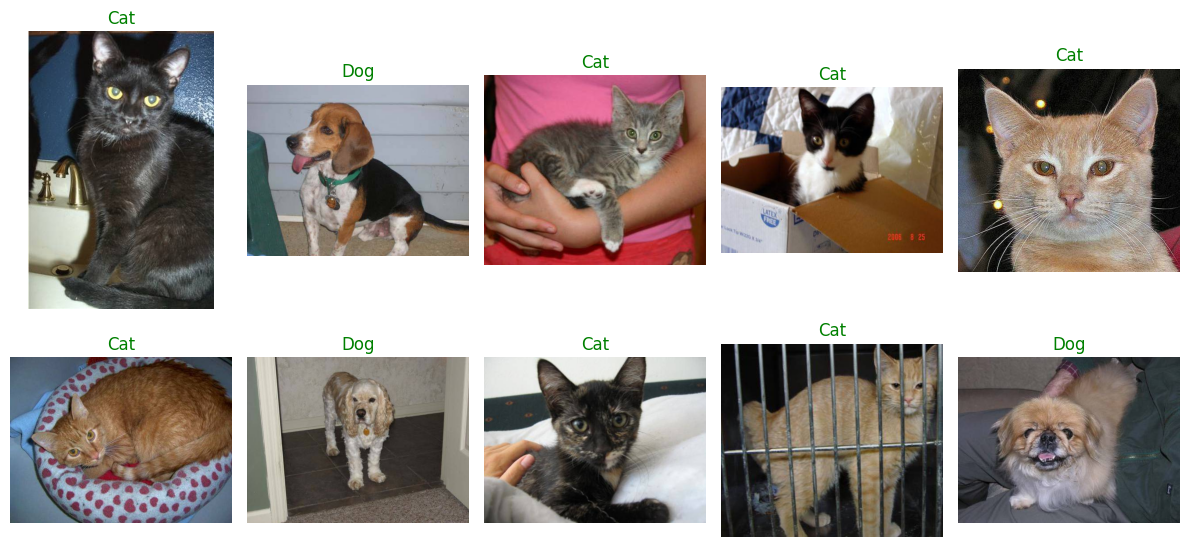

In [8]:
display_image_grid(test_images_filepaths)

### Dataset 정의

데이터셋의 경로를 정의하고, 데이터셋의 크기가 클 수 있기 때문에 **__ init() __**에서 전체 데이터를 읽어오는 것이 아닌, 경로만 저장하고 **__ getitem __**에서 이미지를 읽어온다. 이후 DataLoader에서 데이터셋의 데이터를 메모리로 불러오는데, 모든 데이터를 불러오는 것이 아닌 Batch Size만큼 불러오는 것.

**DogvsCatDataset()**클래스는 데이터를 불러오는 방법을 정의한다. 이 과정에서 label을 'Cat'은 0, 'Dog'는 1이 되도록 코드를 구현한다.

Ex)  img_path = E:/torch/chap06/data/dogs-vs-cats/Dog/dog.113.jpg
**img_path.split('/')[-1].split('.')[0]**
- img_path.split('/')[-1]: img_path를 /기준으로 나눈 후, 마지막 값을 가져온다. (dog.113.jpg)
- .split('.')[0]: .을 기준으로 나눈 후 첫번째 값을 가져온다. (dog)

In [9]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):#data preprocessing을 위해 받는 변수(transform, phase)
        self.file_list = file_list
        self.transform = transform #위에서 정의한 ImageTransform()을 받아올 것이다.
        self.phase = phase #'train'과 'val'에 따라 전치리 과정이 달라진다.

    def __len__(self): # images_filepaths의 전체 길이, 즉 데이터의 양을 구한다.
        return len(self.file_list)

    def __getitem__(self, idx): #data를 가져와서 preprocessing을 진행하고, label을 0,1로 설정한다.(return값은 Tensor)
        img_path = self.file_list[idx] #하나의 이미지 경로
        img = Image.open(img_path) #PIL 라이브러리를 통해 이미지를 가져온다.
        img_transformed = self.transform(img, self.phase)# train에 해당하는 preprocessing진행
        label = img_path.split('/')[-1].split('.')[0] # img_path에서 label값을 추출
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

위에서 정의한 **DogvsCatDataset()** 클래스를 이용하여 데이터셋 정의와 preprocessing을 적용한다.

In [10]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset=DogvsCatDataset(train_images_filepaths,transform=ImageTransform(size,mean,std),phase='train')
val_dataset=DogvsCatDataset(val_images_filepaths,transform=ImageTransform(size,mean,std),phase='val')

index=0
print(train_dataset.__getitem__(index)[0].size()) #전처리된 이미지 size출력
print(train_dataset.__getitem__(index)[1]) #전처리된 이미지 label출력

torch.Size([3, 224, 224])
0


### DataLoader

Pytorch는 DataLoader를 통해 batch를 관리한다. 한꺼번에 모든 데이터를 불러오면 메모리 문제가 발생할 수 있기 때문에 Batch size단위로 학습을 시키는데, 이를 관리하는 것이 DataLoader이다.

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0])


### Model Architecture

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/dd1bc2c2-e8b0-4c62-808b-c0e4c3450a17)

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/bdb4ab17-0f14-452b-b3c1-4c8d4741b71c)

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        # 출력형태는 (weight-kernel_size+1)/stride
        self.cnn1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=0) #input: (3,224,224)/output: (16,220,220)
        self.relu1=nn.ReLU() #Activation function
        self.maxpool1=nn.MaxPool2d(kernel_size=2) #Max pooling(down sampling), input: (16,220,220)/output: (16,110,110)

        self.cnn2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=0) #input: (16,110,110)/output: (32,106,106)
        self.relu2=nn.ReLU()
        self.maxpool2=nn.MaxPool2d(kernel_size=2) #input: (32, 106, 106)/output: (32,53,53)

        #Fully-connected layer
        self.fc1=nn.Linear(32*53*53,512)
        self.relu5=nn.ReLU()
        self.fc2=nn.Linear(512,2)
        self.output=nn.Softmax(dim=1)

    def forward(self,x):
        out=self.cnn1(x)
        out=self.relu1(out)
        out=self.maxpool1(out)
        out=self.cnn2(out)
        out=self.relu2(out)
        out=self.maxpool2(out)
        out=out.view(out.size(0),-1) #데이터를 1차원 형태로 변환(fc layer에 전달하기 위함)

        out=self.fc1(out)
        out=self.fc2(out)
        out=self.output(out)

        return out


In [13]:
model=LeNet() #Model object생성
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


### Model Check

- torchsummary라이브러리를 사용하면 모델의 architecture를 한번에 볼 수 있다.

In [14]:
pip install torchsummary

In [15]:
from torchsummary import summary
summary(model, input_size=(3,224,224)) #model과 input image를 parameter로 설정

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

- count_parameters함수를 정의하여, model에서 학습 가능한 parameter 수를 확인해보자.

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


### Optimizer & Loss Function

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

- model parameter와 loss function을 CPU에 할당한다.(원래는 GPU지만, 이번 예제에서 할당하지 않았기 때문에 device=CPU)

In [18]:
model = model.to(device)
criterion = criterion.to(device)

### Model Training

- ① criterion = nn.CrossEntropyLoss() 코드에서, CrossEntropyLoss()의 reduction파라미터는 defaut값으로 'mean'을 갖는다. criterion = nn.**CrossEntropyLoss(reduction='mean')**은 정답과 예측 값의 오차를 구한 후 그 값들의 평균을 반환한다. 즉, 손실 함수 특성상 전체 오차를 배치 크기로 나눔으로써 평균을 반환하기 때문에 epoch_loss를 계산하는 동안 loss.item()과 inputs.size(0)을 곱해 준다.

- **torch.set_grad_enabled()**는 autograd를 활성화 시킨다. torch.set_grad_enabled(True)일 때, autograd를 활성화시킨다. 따라서 phase=='train'일 때, 즉 training할 때에는 autograd를 활성화하고, validation일 때는 비활성화한다.

-  **model.state_dict()**: 모델의 모든 Weight와 Bias parameter들을 포함하는 dictionary

In [26]:
 def train_model(model,dataloader_dict,criterion,optimizer,num_epoch):
    since=time.time()
    best_acc=0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1,num_epoch))
        print('-'*20)

        for phase in ['train','val']:
            if phase == 'train':
                model.train() #모델 학습
            else:
                model.eval()

            epoch_loss=0.0
            epoch_corrects=0

            for inputs,labels in tqdm(dataloader_dict[phase]): #여기에서 dataloader_dict는 train_loader(training dataset)를 의미
                inputs=inputs.to(device) #training dataset을 CPU에 할당
                labels=labels.to(device)
                optimizer.zero_grad() #back propagation 전 gradient를 0으로 초기화

                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    _,preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels) #criterion은 CrossEntropy Loss

                    if phase == 'train':
                        loss.backward() #learnable한 모든 parameter에 대한 gradient 계산
                        optimizer.step() #optimizer의 step()함수를 호출하면 parameter를 갱신한다.

                    epoch_loss+=loss.item()*inputs.size(0) # ① input과 loss를 곱하는 이유?
                    epoch_corrects+=torch.sum(preds==labels.data)
            epoch_loss=epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_acc=epoch_corrects.double()/len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc=epoch_acc
                best_model_wts=model.state_dict() #가장 성능 좋을 때의 모델의 weight 저장

    time_elapsed=time.time()-since #모델 학습시간
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

- model training을 위해 train_model을 호출(63%정도의 정확도를 보인다)

In [27]:
import time

num_epoch=10
model=train_model(model,dataloader_dict,criterion,optimizer,num_epoch)

Epoch 1/10
--------------------


<ipython-input-26-1153cff7035b>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs,labels in tqdm(dataloader_dict[phase]): #여기에서 dataloader_dict는 train_loader(training dataset)를 의미


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5985 Acc: 0.7175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6729 Acc: 0.5870
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5876 Acc: 0.7175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6363 Acc: 0.6630
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5906 Acc: 0.7325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6520 Acc: 0.6196
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5871 Acc: 0.7150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6357 Acc: 0.6630
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5843 Acc: 0.7125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6453 Acc: 0.6522
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5865 Acc: 0.7100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6351 Acc: 0.6522
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5664 Acc: 0.7550


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6300 Acc: 0.6413
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5735 Acc: 0.7500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6247 Acc: 0.6739
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5859 Acc: 0.7225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6450 Acc: 0.6413
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5930 Acc: 0.7250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6638 Acc: 0.6304
Training complete in 5m 26s
Best val Acc: 0.673913


### Model Test

In [32]:
import pandas as pd

id_list = []
pred_list = []
_id = 0
with torch.no_grad(): #Test이므로 gradient를 계산할 필요가 없다.
    for test_path in tqdm(test_images_filepaths): #Test dataset을 사용한다.
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1] #_id는 dataset에서 data의 번호를 의미
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') #validation과 동일한 preprocessing과정을 거친다.
        img = img.unsqueeze(0) #unsqueeze는 차원을 추가할 때 사용, 0은 차원이 추가될 위치이고 (3) tensor는 (1,3), (2,2) tensor는 (1,2,2) tensor가 된다.
        img = img.to(device)

        model.eval() #model 평가
        outputs = model(img)
        #softmax(,dim=1)함수로 각행의 합이 1이되도록 한다./dim=1은 열을 따라 softmax실행
        preds = F.softmax(outputs, dim=1)[:, 1].tolist() #모든 행의 2번째 열값을 list형태로 반환(즉, label 1의 확률만을 리스트에 저장)
        id_list.append(_id)
        pred_list.append(preds[0]) #pred는 어차피 항상 값이 1개인 list, 또한 preds[0]값은 각 image가 'dog' label일 확률이다.

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})#테스트 데이터셋의 예측 결과인 id와 레이블(label)을 데이터 프레임에 저장

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/Pytorch_study/LeNet', index=False) #데이터 프레임을 CSV 파일로 저장

<ipython-input-32-7db994d9f860>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): #Test dataset을 사용한다.


  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
res.head(10)

,id,label
0,109,0.474286
1,145,0.596636
2,15,0.696705
3,162,0.299592
4,167,0.632945
5,200,0.501430
6,210,0.699819
7,211,0.722778
8,213,0.305466
9,224,0.708599


- Test image를 시각화

In [34]:
class_ = classes = {0:'cat', 1:'dog'} #cat과 dog에 대한 클래스 정의
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)#데이터 프레임의 id라는 칼럼에서 임의로 데이터를 가져온다.
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:# 레이블 값이 0.5보다 크다면 dog
            label = 1
        else:# 레이블 값이 0.5보다 작다면 cat
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

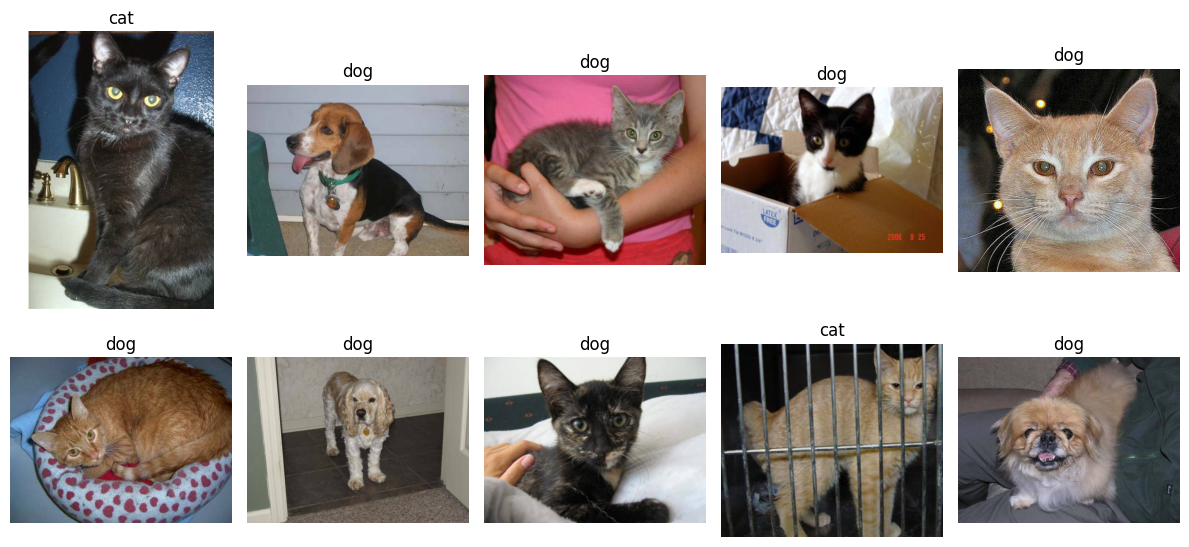

In [35]:
display_image_grid(test_images_filepaths)